## Using SAS DLPy to Create Deep Learning Speech Recognition Models

You can use SAS DLPy to easily create and train a variety of basic task-oriented deep learning models, including RNN models to perform audio analysis for speech recognition tasks. This example notebook uses .wav files of spoken English to create input audio tables for modeling, then creates and trains an RNN speech recognition model. The model network processes the audio inputs and generates textual character transcriptions for the audio features in the data. 

This is a conceptual example that uses a toy data set to build, train, and score (generate textual character transcriptions of) input spoken audio. The notebook includes instructions to download the example data from the [SAS Deep Learning Models and Tools](https://support.sas.com/documentation/prod-p/vdmml/zip/index.html) Web page.

The learning objective of this notebook is to understand how to prepare audio data for deep learning modeling, as well as how to create and train an RNN speech recognition model. The speech recognition model inputs .wav audio files of spoken English phrases, and outputs textual character transcriptions. 

Preparing the audio data for deep modeling is a significant process that can be completed using two methods. 

The first method processes the audio data in separate steps: 

- Create and load an audio table
- Extract audio features
- Loading the audio metadata
- Join the audio and metadata features into a single table.

The first method is useful because it steps through the preparation and data manipulation required to process audio data for modeling. Once that understanding is gained, the second method is more compact and simpler to invoke. With the second method, all of the component tasks are performed in a single call that outputs the required input audio table. 

After preparing the input audio data, use SAS DLPy to define and create an RNN speech recognition model and train the model using the supplied data. Use the trained model to score an audio table and generate textual character transcriptions.

This example assumes that you have SAS DLPy installed, have an active SAS CAS server, and have installed the common Pyton utilities used in the code (numpy, matplotlib, Pandas).

### Table of Contents 
- [Important Note: Client and Server Definitions](#ClientServer)
- [Prepare Resources and Configure Environment for Modeling](#getReady)
    - [Import Required Python and SAS DLPy Modules](#importPythonDLPy)
    - [Download the Audio Data and Speech Recognition Files](#downloadData)
- [Configure SWAT and Launch SAS CAS](#startCAS)
- [Process the Audio Data Files for Modeling](#processAudio)
     - [Create Audio Table and Load Audio Files](#createAudioTable)
     - [Extract the Audio Table Features](#extractAudio)
     - [Load the Ground Truth Audio Metadata](#loadAudMeta)
     - [Join Audio and Metadata Features Together in a Single Table](#joinTable)
- [Create a Deep Learning Audio Table in One Step](#OneShot)
- [Use DLPy to Create an RNN Speech Recognition Model](#createTrainAcoustic)
    - [Train the Acoustic Speech Recognition Model](#trainModel)
- [Use Trained Speech Recognition Model to Score Audio Table](#scoreAudioTable)
- [Summary](#summary)   

<a id = "ClientServer"></a>

### Important Note: Client and Server Definitions
SAS Viya literature and technical documentation often refers to client and server entities. In this scenario, the client is the computer that runs the Jupyter notebook with the example code. The server is the computer that is running the SAS Viya server. These two computers might (or might not) use the same operating system, and might (or might not) have access to a common file system.

Some SAS DLPy functions in this notebook require path values to be supplied using either client-side or server-side formatting. This notebook assumes that the client and server do not use the same operating system, but that they do have access to a common file system. In this case, project files can reside in a single folder that can be accessed by both client-side and server-side paths.

If the client and server in your environment do not have access to a common file system, you will need to copy or transfer project files between client and server folders during this example.

In [1]:
# This code defines server-side and client-side path variables 
# used in the code to specify the location for input audio files,
# the audio files list, and ground truth files for the example.  
# Both paths can point to the same folder in a common file system,  
# but must use approriate server-side and client-side path syntax.

# Server project root location (your path will be different)
server_project_root = r'/your-server-side/path-to/speech-recognition-files'

# Client project root location (your path will be different)
client_project_root = r'\\your-client-side\path-to\speech-recognition-files'

<a id = "getReady"></a>

### Prepare Resources and Configure Computing Environment for Modeling

Use this section to organize all of the resources you need and configure your local computing environment in advance, so you can follow along with the example notebook modeling operations without interruption. 

<a id="importPythonDLPy"></a>

#### Import Required Python and SAS DLPy Modules

Import the Python utilities and SAS DLPy libraries that will be used for the audio training and speech recognition modeling task. Import utilities for the the pandas data analysis library, the numPy scientific computing library, and the matplotlib plotting utility library.

In [2]:
%matplotlib inline

# Import DLPy libraries and functions
import dlpy

from dlpy.audio import AudioTable 
from dlpy import Model
from dlpy import Sequential
 
from dlpy.layers import InputLayer
from dlpy.layers import Conv2d
from dlpy.layers import Pooling
from dlpy.layers import Dense
from dlpy.layers import OutputLayer

from dlpy.applications import SpeechRecognition

from dlpy.model import TextParms, DataSpec, DataSpecNumNomOpts

<a id="downloadData"></a>

#### Download the Audio Data and Speech Recognition Files

Download the toy audio data and speech recognition files used with this notebook example. The files are located on the external [SAS Deep Learning Models and Tools](https://support.sas.com/documentation/prod-p/vdmml/zip/index.html) page. In the `Deep Learning Example Data` section, download the [speech_recognition_example](https://support.sas.com/documentation/prod-p/vdmml/zip/DLPyAudioTrainingData.zip) (280KB) support file.  

Expand the archived support file to the speech recognition project root location that you defined at the beginning of this notebook. The support file archive includes three input audio .wav files (spoken English), an audio listing file, an audio annotations (ground truth) file, and a formatting file `data_clean_replacements_test.txt` that SAS DLPy calls while processing the audio annotations.

<a id="startCAS"></a>

### Configure SWAT and Launch SAS CAS 

SAS DLPy requires a running SAS CAS server and the SAS Scripting Wrapper for Analytic Transfer (SWAT). The SWAT package is a Python interface to SAS CAS. 

Import the SWAT data message handler, then import `StringIO` modules from `io` and `StringIO` to handle text data exceptions. Connect to your SAS CAS server. SAS DLPy examples use a default portID assignment of `5570`, but you can supply your own portID value for your CAS session. After launching SAS CAS, load the CAS `deepLearn` action set. 

<b>Note:</b> For more information about starting a CAS session with the SWAT package, see https://sassoftware.github.io/python-swat/getting-started.html.

In [3]:
# Configure SWAT 

# Import SAS SWAT
import swat
from swat import *

# SWAT data message handler
import swat.cas.datamsghandlers as dmh

# Exception handler for reading StringIO 
# text data into memory
try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO

# Connect to the SAS CAS Server
s = CAS('your-host-name.unx.com', 5570)

# load the SAS CAS DeepLearn action set
s.loadactionset('deeplearn')


NOTE: Added action set 'deeplearn'.


[actionset]

 'deeplearn'

+ Elapsed: 0.00408s, user: 0.00276s, sys: 0.00129s, mem: 0.221mb

<a name="processAudio"></a>

### Process the Audio Data Files for Modeling 

Audio files need to be quantized into numeric vectors before they can be used in deep learning (or any other machine learning) algorithms. This quantization is basically representing sound with a set of descriptors (features).


<a name="createAudioTable"></a>

#### Create Audio Table and Load Audio Files 

The first step to process the audio data is to create an audio table in SAS CAS. The audio table that CAS creates is a table named with the prefix  `AUDIOTABLE_`. The new CAS table is also saved as a Python object named  `au`.  

Use the DLPy `load_audio_files()` function to create `au`. Use your project server root location variable to specify the path to the audio listing file `listingFile.txt`. The listing file is just a list of the project audio files using relative filenames in .txt format. The listing file should reside in the same project folder as the .wav audio files.  

In [4]:
# create an audio table object `au` and 
# load the audio listing file .
au = AudioTable.load_audio_files(s, 
                                 server_project_root+"/listingFile.txt"
                                 )

In [5]:
# Verify that the new audio table 
# was created in SAS CAS.

s.table.tableInfo()

,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,...,Repeated,View,MultiPart,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime
0,AUDIOTABLE_BOQMFF,3,2,0,utf-8,2021-04-27T15:31:29-04:00,2021-04-27T15:31:29-04:00,2021-04-27T15:31:29-04:00,UTF8,1.935171e+09,...,0,0,0,,,0,UserID,,,NaN


 Note that the new table prefixed `AUDIOTABLE_` contains 3 rows (1 for each audio file) and 2 columns. 
 
Examine the toy audio table and its values in the columns `path` and `audio`. Use the `fetch()` function to display the contents of the audio table saved to Python as `au`. The table `au` is a toy table because it contains only 3 rows of data, but it is sufficient for the conceptual audio modeling processes demonstrated in this speech recognition notebook example. 

In [6]:
s.table.fetch(au)

,_path_,_audio_
0,/your-path-to/UserID/speech_recognition/recor...,b'RIFF\xa4\xc7\x01\x00WAVEfmt \x10\x00\x00\x00...
1,/your-path-to/UserID/speech_recognition/recor...,b'RIFF\xa4W\x01\x00WAVEfmt \x10\x00\x00\x00\x0...
2,/your-path-to/UserID/speech_recognition/recor...,b'RIFF\xa4\xaf\x02\x00WAVEfmt \x10\x00\x00\x00...


The fetched audio table displays the path and audio data for the three `.wav` audio files.

<a name="extractAudio"></a>

#### Extract the Audio Table Features

Next, use the DLPy `extract_audio_features()` function to extract audio features from the observations in the audio table. Save the new CAS table of extracted features to Python as `fp`. SAS CAS generates a table name for the extracted audio feature table beginning with the prefix `AUDIOTABLE_`. Unlike the source audio table with two columns, the extracted feature audio table will contain thousands of columns. 

Why is this? Extracting audio features consists of splitting the input audio signal into frames and computing a number of features for each frame. This creates a sequence of feature vectors for the whole signal. The longer the audio signal, the greater the number of frames and analytic features. 

The `copyVars` parameter in the function uses the value saved to the variable `'_path_'` to specify the path to the .wav audio files in the `au` audio table. Then the files can be used to populate the `fp` audio features output table.

In [7]:
# Use DLPy to create an extracted audio feature table from 
# the input audio table in SAS CAS and save the new table to 
# Python as 'fp'.
fp = AudioTable.extract_audio_features(s, 
                                       au, 
                                       copyvars=['_path_']
                                       )

Use the `tableInfo()` function to verify the extracted feature audio table was created. The extracted feature table should contain a large number of columns.

In [8]:
# Verify that the audio features table 
# was created in SAS CAS.

s.table.tableInfo()

,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,...,Repeated,View,MultiPart,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime
0,AUDIOTABLE_BOQMFF,3,2,0,utf-8,2021-04-27T15:31:29-04:00,2021-04-27T15:31:29-04:00,2021-04-27T15:32:38-04:00,UTF8,1.935171e+09,...,0,0,0,,,0,UserID,,,NaN
1,AUDIOTABLE_TY4QRH,3,20003,0,utf-8,2021-04-27T15:32:38-04:00,2021-04-27T15:32:38-04:00,2021-04-27T15:32:38-04:00,UTF8,1.935171e+09,...,0,0,0,,,0,UserID,,,NaN


A second audio table `AUDIOTABLE_TY4QRH` was created. It contains 20,003 columns of extracted features for each input audio signal. Your table name might contain a different suffix, but the table dimensions and contents should match the example.

After creating the audio feature table `fp` with extracted audio features from table `au`, use `fetch()` to display the `fp` table and the frame contents for each unique `.wav` file listed in `_path_`.

In [9]:
s.table.fetch(fp)

,_path_,_num_frames_,_f0_v0_,_f0_v1_,_f0_v2_,_f0_v3_,_f0_v4_,_f0_v5_,_f0_v6_,_f0_v7_,...,_f499_v31_,_f499_v32_,_f499_v33_,_f499_v34_,_f499_v35_,_f499_v36_,_f499_v37_,_f499_v38_,_f499_v39_,_fName_
0,/your-path-to/UserID/speech_recognition/recor...,273,-0.940980,0.013067,-0.172916,0.081758,0.822831,0.763847,2.330542,0.657802,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,recording_2.wav
1,/your-path-to/UserID/speech_recognition/recor...,500,-1.098145,-0.665162,-0.797039,-0.359170,-0.717018,0.041431,-0.703393,-0.012337,...,-0.733043,0.721285,0.58728,0.43753,-0.884352,-1.090778,-0.577482,0.397965,0.11231,recording_3.wav
2,/your-path-to/UserID/speech_recognition/recor...,362,-1.446194,0.244080,-1.150317,0.168909,-0.400322,0.566116,0.961818,0.099415,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,recording_1.wav


<a name="loadAudMeta"></a>

#### Load the Ground Truth Audio Metadata 

Use the SAS DLPy `load_audio_metadata()` function to load the audio metadata into a Python object named `me` . The function requires the client-side path to the input audio metadata (ground truth) `groundTruth.txt` file, as well as the server-side path to the audio .wav files.

While perfroming the `load_audio_metadata()` function, SAS DLPy uses the file `data_clean_replacement.txt` to parse the text in the `groundTruth.txt` file. This action formats the file for use by DLPy. It replaces any symbols found in the ground truth text with spaces or phrases.  

When performing deep learning with audio inputs, the term 'ground truth' refers to the actual contents of an audio file. For this example, the ground truth for each observation is a text transcription of the spoken words.

Because of the way the `load_audio_metadata()` function operates, the path sepcification for the ground truth file must be a client-side path, and the path specification to the .wav audio files must be a server-side path. In an environment with common operating systems, the two paths can point to the same folder, but each path specification must use appropriate client-side and server-side syntax.

In [10]:
# Create CAS audio table saved as 'me' in Python. 
# load audio metadata. Specify client-side path to 
# audio metadata (ground truth) file. Specify 
# server-side path to the source audio files. 

me = AudioTable.load_audio_metadata(s,
                                    # Client-side path to ground truth file
                                    client_project_root+'\groundTruth.txt',                                    
                                                                        
                                    # server path to audio files 
                                    server_project_root                                      
                                   )

...using default replacements file from datasource dir
...reading in C:\Users\UserID\...\data_clean_replacements.txt
...reading in \\your-path-to\UserID\speech_recognition\groundTruth.txt 
recording_1.wav He made a sales call he says.
recording_2.wav It wasn\'t a giveaway.
recording_3.wav The gates and corridors were designed for smaller aircraft.
...found the longest line with text length of 58
...The gates and corridors were designed for smaller aircraft
NOTE: Cloud Analytic Services made the uploaded file available as table AUDIOTABLE_METADATA_4DQEXL in caslib CASUSER(UserID).
NOTE: The table AUDIOTABLE_METADATA_4DQEXL has been created in caslib CASUSER(UserID) from binary data uploaded to Cloud Analytic Services.


In [11]:
# Verify that the audio metadata table 
# is created in SAS CAS.

s.table.tableInfo()

,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,...,Repeated,View,MultiPart,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime
0,AUDIOTABLE_BOQMFF,3,2,0,utf-8,2021-04-27T15:31:29-04:00,2021-04-27T15:31:29-04:00,2021-04-27T15:32:38-04:00,UTF8,1.935171e+09,...,0,0,0,,,0,UserID,,,NaN
1,AUDIOTABLE_TY4QRH,3,20003,0,utf-8,2021-04-27T15:32:38-04:00,2021-04-27T15:32:38-04:00,2021-04-27T15:34:10-04:00,UTF8,1.935171e+09,...,0,0,0,,,0,UserID,,,NaN
2,AUDIOTABLE_METADATA_4DQEXL,3,62,0,utf-8,2021-04-27T15:34:20-04:00,2021-04-27T15:34:20-04:00,2021-04-27T15:34:20-04:00,UTF8,1.935171e+09,...,0,0,0,,,0,UserID,,,NaN


Audio metadata table `AUDIOTABLE_METADATA_4DQEXL` was created in SAS CAS and saved as Python table `me`. 

During audio metadata table creation, the longest character string in `groundTruth.txt` is counted. The `load_audio_metadata()` log above shows that the longest text string in `groundTruth.txt` is 58 characters. As a result, the audio metadata table will contain 58 Yn text character columns (Y0...Y57). The successive Yn column characters in an observation form the ground truth text phrase for an individual input audio .wav file. 

Use `fetch()` with Python table name `me` to display the contents of the newly created CAS audio metadata table `AUDIOTABLE_METADATA_4DQEXL` with the Yn columns: 

In [12]:
s.table.fetch(me)

,_filename_,y0,y1,y2,y3,y4,y5,y6,y7,y8,...,y51,y52,y53,y54,y55,y56,y57,ylen,_path_,_fName_
0,recording_1.wav,H,e,~,m,a,d,e,~,a,...,~,~,~,~,~,~,~,28.0,/your-path-to/UserID/speech_recognition/recor...,recording_1.wav
1,recording_2.wav,I,t,~,w,a,s,n,',t,...,~,~,~,~,~,~,~,20.0,/your-path-to/UserID/speech_recognition/recor...,recording_2.wav
2,recording_3.wav,T,h,e,~,g,a,t,e,s,...,i,r,c,r,a,f,t,58.0,/your-path-to/UserID/speech_recognition/recor...,recording_3.wav


<a name="joinTable"></a>

#### Join Audio and Metadata Features Together in a Single Table

So far, the example has an audio features table `fp` and an audio metadata table `me`. Use the DLPy `dlJoin()` function to join the audio and metadata features together, and create a new CAS output table named `test_features_with_labels`. 

The SAS DLPy `dlJoin()` function parameters include the annotation (ground truth) table `me`, the extracted audio features table `fp`, the observation identifier `id` (contained in the value stored for the unique observation `_path_`), and the name of the CAS output table `test_features_with_labels`. 

In [13]:
# Join the ground truth and extracted features tables
         # Ground truth table
s.dlJoin(annotation=me,
         # Extracted features table
         table=fp,
         # Observation identifier
         id='_fName_',
         # CAS Output table name.
         casOut=dict(name='test_features_with_labels')
         )

,casLib,Name,Rows,Columns,casTable
0,CASUSER(UserID),test_features_with_labels,3,20063,"CASTable('test_features_with_labels', caslib='..."


Now use `fetch()` to display the resulting joined table `test_features_with_labels` that contains the combined audio and metadata features. The joined table contains 20,003 columns of extracted feature vector value frames `_fn_vn_` as well as 58 columns of ground truth text characters `Yn` for each observation. There are 2 additional summary columns in each observation: the extracted audio frame count `_num_frames_`, and the ground truth text character string count `Ylen`. In total, there are 20,063 columns in the joined table.  

In [14]:
s.table.fetch('test_features_with_labels')

,_fName_,_path_,_num_frames_,_f0_v0_,_f0_v1_,_f0_v2_,_f0_v3_,_f0_v4_,_f0_v5_,_f0_v6_,...,y49,y50,y51,y52,y53,y54,y55,y56,y57,ylen
0,recording_2.wav,/your-path-to/UserID/speech_recognition/recor...,273.0,-0.940980,0.013067,-0.172916,0.081758,0.822831,0.763847,2.330542,...,~,~,~,~,~,~,~,~,~,20.0
1,recording_3.wav,/your-path-to/UserID/speech_recognition/recor...,500.0,-1.098145,-0.665162,-0.797039,-0.359170,-0.717018,0.041431,-0.703393,...,~,a,i,r,c,r,a,f,t,58.0
2,recording_1.wav,/your-path-to/UserID/speech_recognition/recor...,362.0,-1.446194,0.244080,-1.150317,0.168909,-0.400322,0.566116,0.961818,...,~,~,~,~,~,~,~,~,~,28.0


<a id="OneShot"></a>

### Create a Deep Learning Audio Table in One Step

So far, the example has taken a stepwise approach to creating an audio table for use with a speech recognition model. It is important to understand the audio table creation process as well as the purpose of the component tables used during audio table creation.

The stepwise process to create an audio table is longer, but provides flexibility. If you understand the audio table creation process and have no special needs, you can use a simple comprehensive call to perform all of the tasks in a single step.

The following code uses the DLPy `AudioTable.create_audio_table()` function from the DLPy `AudioTable` module to create a CAS audio table saved to Python as `au_table` by specifying the server-side path to the audio source files, and the client-side path to the audio metadata "ground truth" file.

In [15]:
from dlpy.audio import AudioTable


au_table = AudioTable.create_audio_table(s,
                                         # server-side path to audio source files
                                         server_project_root+'/listingFile.txt',
                                         
                                         # client-side path to ground truth file
                                         client_project_root+'\groundTruth.txt'
                                         )                             

...using default replacements file from datasource dir
...reading in C:\Users\UserID\...\data_clean_replacements.txt
...reading in \\your-path-to\UserID\speech_recognition\groundTruth.txt
recording_1.wav He made a sales call he says.
recording_2.wav It wasn\'t a giveaway.
recording_3.wav The gates and corridors were designed for smaller aircraft. 
...found the longest line with text length of 58: 
...The gates and corridors were designed for smaller aircraft
NOTE: Cloud Analytic Services made the uploaded file available as table AUDIOTABLE_METADATA_LWX4XT in caslib CASUSER(UserID).
NOTE: The table AUDIOTABLE_METADATA_LWX4XT has been created in caslib CASUSER(UserID) from binary data uploaded to Cloud Analytic Services.
...located newly created table AudioTable_Metadata_LWx4XT in caslib None 


The CAS audio metadata table `AUDIOTABLE_METADATA_LWX4XT` is created and saved to Python as `au_table` in one step.

In [16]:
# Verify that the new audio table AUDIOTABLE_METADATA_LWX4XT
# is created in SAS CAS.

s.table.tableInfo()

,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,...,Repeated,View,MultiPart,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime
0,AUDIOTABLE_BOQMFF,3,2,0,utf-8,2021-04-27T15:31:29-04:00,2021-04-27T15:31:29-04:00,2021-04-27T15:32:38-04:00,UTF8,1.935171e+09,...,0,0,0,,,0,UserID,,,NaN
1,AUDIOTABLE_TY4QRH,3,20003,0,utf-8,2021-04-27T15:32:38-04:00,2021-04-27T15:32:38-04:00,2021-04-27T15:35:52-04:00,UTF8,1.935171e+09,...,0,0,0,,,0,UserID,,,NaN
2,AUDIOTABLE_METADATA_4DQEXL,3,62,0,utf-8,2021-04-27T15:34:20-04:00,2021-04-27T15:34:20-04:00,2021-04-27T15:35:52-04:00,UTF8,1.935171e+09,...,0,0,0,,,0,UserID,,,NaN
3,TEST_FEATURES_WITH_LABELS,3,20063,0,utf-8,2021-04-27T15:35:55-04:00,2021-04-27T15:35:55-04:00,2021-04-27T15:36:02-04:00,UTF8,1.935171e+09,...,0,0,0,,,0,UserID,,,NaN
4,AUDIOTABLE_R8UGDZ,3,2,0,utf-8,2021-04-27T15:36:14-04:00,2021-04-27T15:36:14-04:00,2021-04-27T15:36:14-04:00,UTF8,1.935171e+09,...,0,0,0,,,0,UserID,,,NaN
5,AUDIOTABLE_B4FC1H,3,20003,0,utf-8,2021-04-27T15:36:15-04:00,2021-04-27T15:36:15-04:00,2021-04-27T15:36:15-04:00,UTF8,1.935171e+09,...,0,0,0,,,0,UserID,,,NaN
6,AUDIOTABLE_METADATA_LWX4XT,3,62,0,utf-8,2021-04-27T15:36:15-04:00,2021-04-27T15:36:15-04:00,2021-04-27T15:36:15-04:00,UTF8,1.935171e+09,...,0,0,0,,,0,UserID,,,NaN
7,AUDIOTABLE_KLPGN7,3,20063,0,utf-8,2021-04-27T15:36:18-04:00,2021-04-27T15:36:18-04:00,2021-04-27T15:36:18-04:00,UTF8,1.935171e+09,...,0,0,0,,,0,UserID,,,NaN


Now use `fetch()` with Python table object `au_table` to display the contents of the new audio table that was created in one step:

In [17]:
s.table.fetch(au_table)

,_fName_,_path_,_num_frames_,_f0_v0_,_f0_v1_,_f0_v2_,_f0_v3_,_f0_v4_,_f0_v5_,_f0_v6_,...,y49,y50,y51,y52,y53,y54,y55,y56,y57,ylen
0,recording_2.wav,/your-path-to/UserID/speech_recognition/recor...,273,-0.940980,0.013067,-0.172916,0.081758,0.822831,0.763847,2.330542,...,~,~,~,~,~,~,~,~,~,20.0
1,recording_1.wav,/your-path-to/UserID/speech_recognition/recor...,362,-1.446194,0.244080,-1.150317,0.168909,-0.400322,0.566116,0.961818,...,~,~,~,~,~,~,~,~,~,28.0
2,recording_3.wav,/your-path-to/UserID/speech_recognition/recor...,500,-1.098145,-0.665162,-0.797039,-0.359170,-0.717018,0.041431,-0.703393,...,~,a,i,r,c,r,a,f,t,58.0


The contents of the audio table `au` (created using the multi-step process) and the contents of the audio table `au_table` (created using the single step process) are almost identical. There are very small differences that come from additional dithering that is added to the original audio signal before extracting acoustic features in the comprehensive approach. 

<a name="createTrainAcoustic"></a>

### Use DLPy to Create an RNN Speech Recognition Model

Now that you have an audio table ready for modeling, use SAS DLPy to create and train an RNN model to perform speech recognition tasks. Use the DLPy `SpeechRecognition()` function to create an acoustic RNN model named `acoustic_model`. The model should have 15 neurons and one bi-directional block:

In [18]:
# Use DLPy to create a deep learning speech 
# recognition model named acoustic_model
acoustic_model = SpeechRecognition(s, 
                                   neurons=15, 
                                   n_blocks=1
                                   )

NOTE: Output layer added.
NOTE: Model compiled successfully.


As an additional exercise, uncomment the code block below and use the Graphviz `plot_network()` function to display a plot of the network DAG (Direct Acyclic Graph):

In [ ]:
# Plot a DAG of the RNN speech recognition model

# acoustic_model.plot_network()

The generated DAG for the acoustic model should resemble the following:

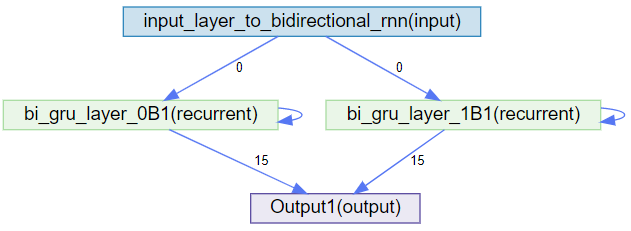

The following code establishes naming conventions for the audio table columns. The audio table columns contain sequential frame `f` and value `v` pairs. This generates column names such as`_f0_v0_`, `_f0_v1_`,` _f0_v2_`... and so on. The column names match each frame pair in the audio table, and are used as inputs. 

Columns with names that begin with `y`, such as `y0`, `y1`, and so on are the target values.

In [19]:
# Generate frame-and-value pair column names
# for the audio table

inputVars = []
targetVars = []
for f in range(0,500):
    for v in range(0,40):
        colName = '_f' + str(f) + '_v' + str(v) + '_'
        inputVars.append(colName)
for t in range(0,57):
    colName = 'y' + str(t)
    targetVars.append(colName)

<a id="trainModel"></a>

#### Train the Acoustic Speech Recognition Model 

Now use the `fit()` function with `acoustic_model` to train the RNN acoustic speech recognition model using the data in the audio table `au_table`. The RNN model uses `numericnominal` input and output layers, trains for a maximum of 5 epochs, and has a learning rate of 0.001. Values for `seed` and `record_seed` are provided for determinism purposes and to provide repeatable trained model results. The `log_level=2` specification provides basic model log details.

In [20]:
# Train the acoustic model
# DataSpec layers should be the same 
# as the layer names in the model.
acoustic_model.fit(data=au_table, 
                   data_specs=[DataSpec(type_='numericnominal', 
                                        layer='input_layer_to_bidirectional_rnn', 
                                        data=inputVars, 
                                        numeric_nominal_parms=DataSpecNumNomOpts(token_size=40, 
                                                                                 length='_num_frames_'
                                                                                 )
                                        ), 
                               DataSpec(type_='numericnominal', 
                                        layer='Output1', 
                                        data=targetVars, 
                                        numeric_nominal_parms=DataSpecNumNomOpts(token_size=1,
                                                                                 length='ylen'
                                                                                 )
                                        )
                               ],
                   seed=867,
                   record_seed=5309,
                   max_epochs=5, 
                   log_level=2,
                   lr=0.001)

NOTE: Training from scratch.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 5784.
NOTE:  The approximate memory cost is 62.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       0.15 (s).
NOTE:  The total number of threads on each worker is 56.
NOTE:  The maximum mini-batch size per thread on each worker is 1.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 56.
NOTE:  Target variable: y0
NOTE:  Number of levels for the target variable:     24
NOTE:  Levels for the target variable:
NOTE:  Level      0: '
NOTE:  Level      1: ~
NOTE:  Level      2: a
NOTE:  Level      3: c
NOTE:  Level      4: d
NOTE:  Level      5: e
NOTE:  Level      6: f
NOTE:  Level      7: g
NOTE:  Level      8: h
NOTE:  Level      9: H
NOTE:  Level     10: i
NOTE:  Level     11: I
NOTE:  Level     12: l
NOTE:  Level     13: m
NOTE:  Level     14: n
NOTE:  Level     15: o
NOTE:  Level     16: r
NOTE:  Level     17: 

,Descr,Value
0,Model Name,acoustic_model
1,Model Type,Recurrent Neural Network
2,Number of Layers,4
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,0
6,Number of Pooling Layers,0
7,Number of Fully Connected Layers,0
8,Number of Recurrent Layers,2
9,Number of Weight Parameters,5670


The trained model `model` consists of multiple layers: 1 input layer, 1 bi-directional block (2 recurrent layers), and 1 output layer. After 5 epochs, the trained model is output with 5,784 parameters.

<a name="scoreAudioTable"></a>

### Use Trained Speech Recognition Model to Score Audio Table

Now use the DLPy `predict()` function with the trained RNN model `acoustic_model` to score the audio table `au_table`. The score task seeks to generate textual character transcriptions for the audio features in the modeled data.

In [21]:
# Use trained model `acoustic_model` to score 
# the audio table and generate character  
# transcriptions of the audio features.
acoustic_model.predict(data=au_table)

# Display the first three rows of the
# scored audio table.
acoustic_model.valid_res_tbl.fetch(to=3)

NOTE: Due to data distribution, miniBatchSize has been limited to 3.


,_fName_,_path_,_num_frames_,_f0_v0_,_f0_v1_,_f0_v2_,_f0_v3_,_f0_v4_,_f0_v5_,_f0_v6_,...,_DL_P499_17_,_DL_P499_18_,_DL_P499_19_,_DL_P499_20_,_DL_P499_21_,_DL_P499_22_,_DL_P499_23_,_DL_PredName499_,_DL_PredP499_,_DL_PredLevel499_
0,recording_2.wav,/your-path-to/UserID/speech_recognition/recor...,273,-0.940980,0.013067,-0.172916,0.081758,0.822831,0.763847,2.330542,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,,0.000000,-1.0
1,recording_1.wav,/your-path-to/UserID/speech_recognition/recor...,362,-1.446194,0.244080,-1.150317,0.168909,-0.400322,0.566116,0.961818,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,,0.000000,-1.0
2,recording_3.wav,/your-path-to/UserID/speech_recognition/recor...,500,-1.098145,-0.665162,-0.797039,-0.359170,-0.717018,0.041431,-0.703393,...,0.012598,0.011332,0.025001,0.011739,0.009189,0.008989,0.662388,,0.662388,23.0


Once raw predictions are received, they are usually post-processed via language modeling to refine the textual character transcription vector results into spoken text. 

<a id="summary"></a>

### Summary

It is relatively easy to create and modify task-centric models using SAS DLPy. This example showed different ways to create an audio table for speech recognition modeling, as well as how to create an RNN deep learning speech recognition model network.